In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from Morning Star
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb

# For time stamps

import datetime
# For division
from __future__ import division

# Import cufflink and plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
# allow notebook access visualization
cf.go_offline()

In [2]:
# Plot defaults 
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15

In [3]:
# Import Facebook stock price
FB = pd.read_csv("FB.csv")
FB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
Date         159 non-null object
Open         159 non-null float64
High         159 non-null float64
Low          159 non-null float64
Close        159 non-null float64
Adj Close    159 non-null float64
Volume       159 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


In [4]:
FB.head()
FB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
Date         159 non-null object
Open         159 non-null float64
High         159 non-null float64
Low          159 non-null float64
Close        159 non-null float64
Adj Close    159 non-null float64
Volume       159 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


In [5]:
FB["Date"] = pd.to_datetime(FB["Date"])

In [6]:
FB.set_index("Date", inplace = True)

Text(0.5,1,'Facebook Historical Data')

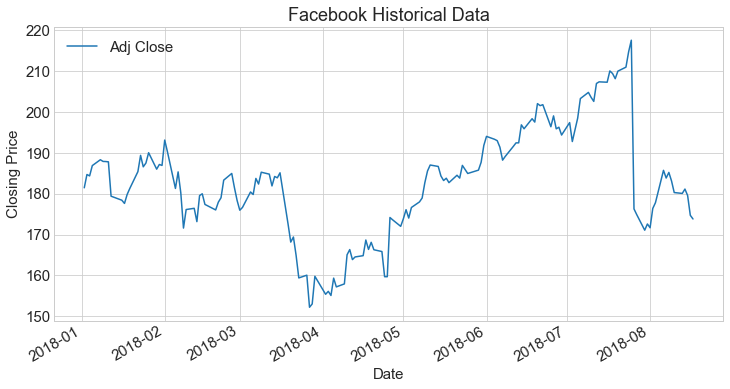

In [7]:
# Plotting the closing price
FB.plot( y = "Adj Close", legend = True, )
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Facebook Historical Data")


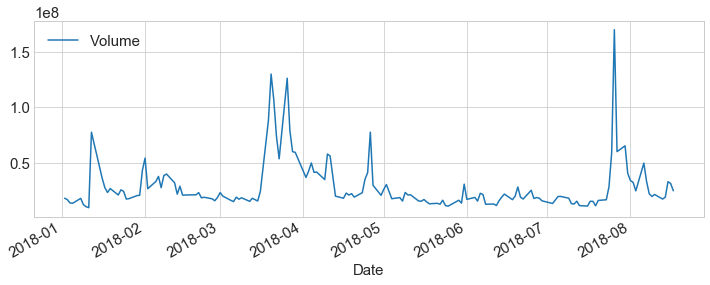

In [8]:
FB["Volume"].plot(legend = True, figsize = (12,4))

In [9]:
# Create a moving average technical analysis for Facebook
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    FB[column_name]=pd.rolling_mean(FB['Adj Close'],ma)

/Users/huy/Documents/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()

/Users/huy/Documents/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()

/Users/huy/Documents/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()



In [10]:
FB[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].iplot(subplots=False)

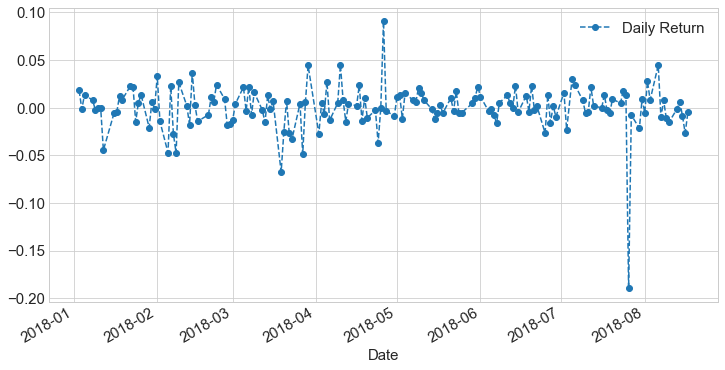

In [11]:
# Using pct_change to find the percent change for each day
FB['Daily Return'] = FB['Adj Close'].pct_change()

# Plot the daily return percentage
FB['Daily Return'].plot(figsize=(12,6),legend=True,linestyle='--',marker='o')
FB['Daily Return'].iplot(kind = "bar", legend=True,symbol='dot', size=12)

In [12]:
FB['Daily Return'].head()

Date
2018-01-02         NaN
2018-01-03    0.017914
2018-01-04   -0.001841
2018-01-05    0.013671
2018-01-08    0.007653
Name: Daily Return, dtype: float64

/Users/huy/Documents/Anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



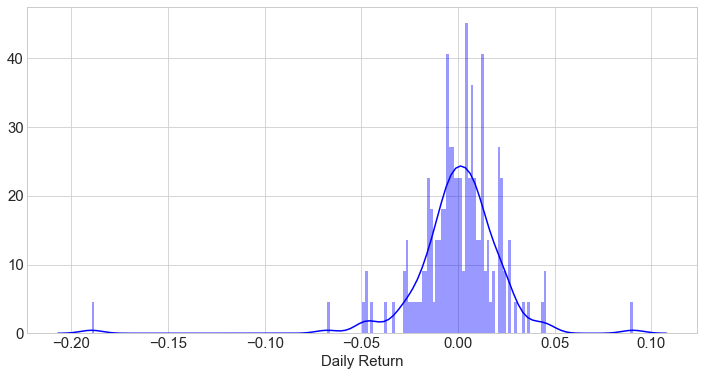

In [13]:
sns.distplot(FB['Daily Return'].dropna(),bins=200,color='b')

In [14]:
# use quantile to get risk value for stock
returns = FB['Daily Return'].dropna()
# The 0.05 empirical quantile of daily returns
returns.quantile(0.05)

-0.028534198989581747

The 0.05 empirical quantile of daily returns is at -0.0268. That means that with 95% confidence, our worst daily loss will not exceed 2.68%. If we have a 1 million dollar investment, our one-day 5% VaR is 0.0268 * 1,000,000 = $26,819.

## Montecarlo Simulation for Facebook stock
The simulation use the Geometric Brownian Motion (GBM), meaning that the stock price follows a random walk and is consistent with (at the very least) the weak form of the efficient market hypothesis (EMH) – past price information can reflect future price.

\begin{align}
\delta{S} & =  S (\mu \delta{t} + \sigma \epsilon \sqrt(\delta{t})
\end{align}

##### where: 
* "S" is the stock price,
* \begin{align} \mu \end{align} is the expected return, 
* \begin{align} \sigma \end{align} is the standard deviation of returns, 
* "t" is time
* \begin{align} \epsilon \end{align} is the random variable.

"The equation composes of two part: the drift and the shock.
For each time period, our model assumes the price will "drift" up by the expected return. But the drift will be shocked (added or subtracted) by a random shock. The random shock will be the standard deviation "s" multiplied by a random number "e." This is simply a way of scaling the standard deviation." (Investopedia - https://www.investopedia.com/articles/07/montecarlo.asp)

In [15]:
# Set up our time horizon
days = 360
dt = 1/days
mu = returns.mean()
sigma = returns.std()

In [16]:
def stock_monte_carlo(start_price,days,mu,sigma):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price
    
    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in range(1,days):
        
        # Calculate Shock
        shock[x] = np.random.normal(loc = mu * dt, scale =  sigma * np.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

Text(0.5,1,'Monte Carlo Analysis for Facebook')

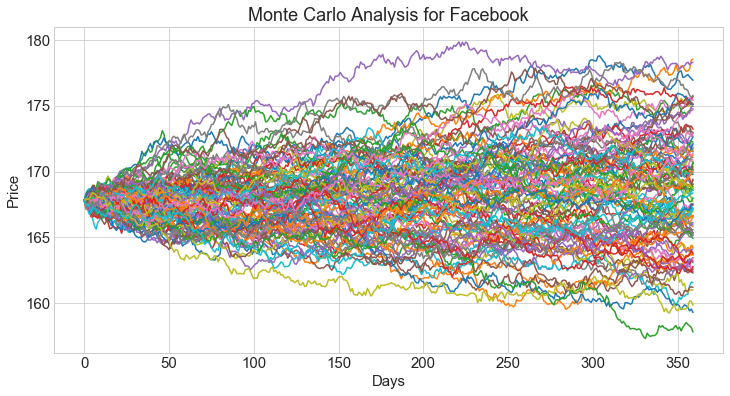

In [17]:
# Get start price from C.tail()
start_price = 167.78

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Facebook')

# Now run 1000 times and plot in histogram

In [18]:
# Set a large numebr of runs
runs = 1000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
#np.set_printoptions(threshold=5)

for run in range(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1];

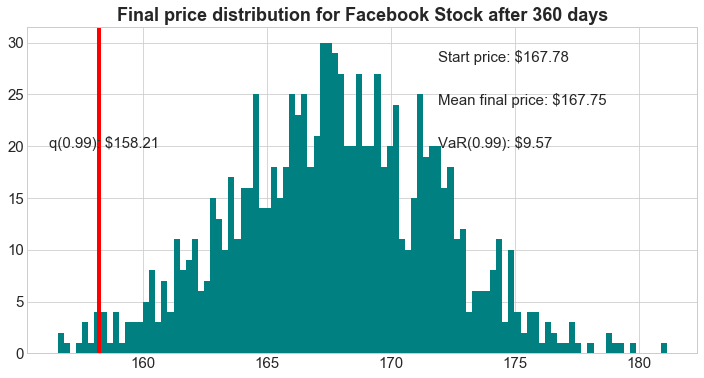

In [19]:
# Now we'll define q as the 1-percentile
# this means that 99% of the values should fall above a certain price
q = np.percentile(simulations, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations,bins=100, color= "teal")

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1-percentile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for Facebook Stock after %s days" % days, weight='bold');